In [6]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import os, sys, pathlib, random, time, pickle, copy, json
from tqdm import tqdm

In [7]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

In [8]:
# SEED = 147
# SEED = 258
SEED = 369

torch.manual_seed(SEED)
np.random.seed(SEED)

In [9]:
import torch.optim as optim
from torch.utils import data

In [10]:
cifar_train = transforms.Compose([
    transforms.RandomCrop(size=32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465], # mean=[0.5071, 0.4865, 0.4409] for cifar100
        std=[0.2023, 0.1994, 0.2010], # std=[0.2009, 0.1984, 0.2023] for cifar100
    ),
])

cifar_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465], # mean=[0.5071, 0.4865, 0.4409] for cifar100
        std=[0.2023, 0.1994, 0.2010], # std=[0.2009, 0.1984, 0.2023] for cifar100
    ),
])

train_dataset = datasets.CIFAR10(root="../../../../../_Datasets/cifar10/", train=True, download=True, transform=cifar_train)
test_dataset = datasets.CIFAR10(root="../../../../../_Datasets/cifar10/", train=False, download=True, transform=cifar_test)

0it [00:00, ?it/s]

Extracting ../../../../../_Datasets/cifar10/cifar-10-python.tar.gz to ../../../../../_Datasets/cifar10/
Files already downloaded and verified


In [12]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [13]:
## demo of train loader
xx, yy = iter(train_loader).next()
xx.shape

torch.Size([32, 3, 32, 32])

# Model

In [14]:
class MlpBLock(nn.Module):
    
    def __init__(self, input_dim, hidden_layers_ratio=[2], actf=nn.GELU):
        super().__init__()
        self.input_dim = input_dim
        #### convert hidden layers ratio to list if integer is inputted
        if isinstance(hidden_layers_ratio, int):
            hidden_layers_ratio = [hidden_layers_ratio]
            
        self.hlr = [1]+hidden_layers_ratio+[1]
        
        self.mlp = []
        ### for 1 hidden layer, we iterate 2 times
        for h in range(len(self.hlr)-1):
            i, o = int(self.hlr[h]*self.input_dim),\
                    int(self.hlr[h+1]*self.input_dim)
            self.mlp.append(nn.Linear(i, o))
            self.mlp.append(actf())
        self.mlp = self.mlp[:-1]
        
        self.mlp = nn.Sequential(*self.mlp)
        
    def forward(self, x):
        return self.mlp(x)

In [15]:
MlpBLock(2, [3,4])

MlpBLock(
  (mlp): Sequential(
    (0): Linear(in_features=2, out_features=6, bias=True)
    (1): GELU()
    (2): Linear(in_features=6, out_features=8, bias=True)
    (3): GELU()
    (4): Linear(in_features=8, out_features=2, bias=True)
  )
)

## MLP-Mixer 

In [16]:
class MixerBlock(nn.Module):
    
    def __init__(self, patch_dim, channel_dim):
        super().__init__()
        
        self.ln0 = nn.LayerNorm(channel_dim)
        self.mlp_patch = MlpBLock(patch_dim, [2])
        self.ln1 = nn.LayerNorm(channel_dim)
        self.mlp_channel = MlpBLock(channel_dim, [2])
    
    def forward(self, x):
        ## x has shape-> N, nP, nC/hidden_dims; C=Channel, P=Patch
        
        ######## !!!! Can use same mixer on shape of -> N, C, P;
        
        #### mix per patch
        y = self.ln0(x) ### per channel layer normalization ?? 
        y = torch.swapaxes(y, -1, -2)
        y = self.mlp_patch(y)
        y = torch.swapaxes(y, -1, -2)
        x = x+y
        
        #### mix per channel 
        y = self.ln1(x)
        y = self.mlp_channel(y)
        x = x+y
        return x

In [17]:
class MlpMixer(nn.Module):
    
    def __init__(self, image_dim:tuple, patch_size:tuple, hidden_expansion:float, num_blocks:int, num_classes:int):
        super().__init__()
        
        self.img_dim = image_dim ### must contain (C, H, W) or (H, W)
        
        ### find patch dim
        d0 = int(image_dim[-2]/patch_size[0])
        d1 = int(image_dim[-1]/patch_size[1])
        assert d0*patch_size[0]==image_dim[-2], "Image must be divisible into patch size"
        assert d1*patch_size[1]==image_dim[-1], "Image must be divisible into patch size"
#         self.d0, self.d1 = d0, d1 ### number of patches in each axis
        __patch_size = patch_size[0]*patch_size[1]*image_dim[0] ## number of channels in each patch
    
        ### find channel dim
        channel_size = d0*d1 ## number of patches
        
        ### after the number of channels are changed
        init_dim = __patch_size
        final_dim = int(patch_size[0]*patch_size[1]*hidden_expansion)
        self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
        #### rescale the patches (patch wise image non preserving transform, unlike bilinear interpolation)
        self.channel_change = nn.Linear(init_dim, final_dim)
        print(f"MLP Mixer : Channes per patch -> Initial:{init_dim} Final:{final_dim}")
        
        
        self.channel_dim = final_dim
        self.patch_dim = channel_size
        
        self.mixer_blocks = []
        for i in range(num_blocks):
            self.mixer_blocks.append(MixerBlock(self.patch_dim, self.channel_dim))
        self.mixer_blocks = nn.Sequential(*self.mixer_blocks)
        
        self.linear = nn.Linear(self.patch_dim*self.channel_dim, num_classes)
        
        
    def forward(self, x):
        bs = x.shape[0]
        x = self.unfold(x).swapaxes(-1, -2)
        x = self.channel_change(x)
        x = self.mixer_blocks(x)
        x = self.linear(x.view(bs, -1))
        return x

In [18]:
mixer = MlpMixer((1, 28, 28), (4, 4), hidden_expansion=2, num_blocks=1, num_classes=10)
mixer

MLP Mixer : Channes per patch -> Initial:16 Final:32


MlpMixer(
  (unfold): Unfold(kernel_size=(4, 4), dilation=1, padding=0, stride=(4, 4))
  (channel_change): Linear(in_features=16, out_features=32, bias=True)
  (mixer_blocks): Sequential(
    (0): MixerBlock(
      (ln0): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=49, out_features=98, bias=True)
          (1): GELU()
          (2): Linear(in_features=98, out_features=49, bias=True)
        )
      )
      (ln1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (mlp_channel): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
          (1): GELU()
          (2): Linear(in_features=64, out_features=32, bias=True)
        )
      )
    )
  )
  (linear): Linear(in_features=1568, out_features=10, bias=True)
)

In [19]:
# mixer(torch.randn(3, 1, 28, 28))

## Patch Mixer

In [20]:
class PatchMixerBlock(nn.Module):
    
    def __init__(self, patch_size, num_channel):
        super().__init__()
        self.patch_size = patch_size
        
#         self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
        ps = None
        if isinstance(patch_size, int):
            ps = patch_size**2
        else:
            ps = patch_size[0]*patch_size[1]
        ps = ps*num_channel
        
        self.ln0 = nn.LayerNorm(ps)
        self.mlp_patch = MlpBLock(ps, [2])
        
#         self.fold = nn.Fold(kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        ## x has shape-> N, C, H, W; C=Channel
        
        sz = x.shape
        
        y = nn.functional.unfold(x, 
                                 kernel_size=self.patch_size, 
                                 stride=self.patch_size
                                )
        #### mix per patch
        y = torch.swapaxes(y, -1, -2)
        y = self.ln0(y) 
        y = self.mlp_patch(y)
        y = torch.swapaxes(y, -1, -2)
        
        y = nn.functional.fold(y, (sz[-2], sz[-1]), 
                               kernel_size=self.patch_size, 
                               stride=self.patch_size
                              )
        x = x+y
        return x

In [21]:
pmb = PatchMixerBlock(8, 3)
pmb

PatchMixerBlock(
  (ln0): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  (mlp_patch): MlpBLock(
    (mlp): Sequential(
      (0): Linear(in_features=192, out_features=384, bias=True)
      (1): GELU()
      (2): Linear(in_features=384, out_features=192, bias=True)
    )
  )
)

In [22]:
# pmb(torch.randn(1, 3, 35, 35)).shape

In [57]:
def get_factors(n):
    facts = []
    for i in range(2, n+1):
        if n%i == 0:
            facts.append(i)
    return facts

class PatchMlpMixer(nn.Module):
    
    def __init__(self, image_dim:tuple, patch_sizes:tuple, hidden_channels:int, num_blocks:int, num_classes:int):
        super().__init__()
        
        self.img_dim = image_dim ### must contain (C, H, W)
        self.target_dim = np.prod(patch_sizes)
        
        ### find number of channel for input, the channel is 
        num_channel = image_dim[0]
        
        self.conv1x1 = nn.Conv2d(num_channel, hidden_channels, kernel_size=1, stride=1)
        
        self.mixer_blocks = []
        for i in range(num_blocks):
            for ps in patch_sizes:
                self.mixer_blocks.append(PatchMixerBlock(ps, hidden_channels))
                
        self.mixer_blocks = nn.Sequential(*self.mixer_blocks)
        self.linear = nn.Linear(self.target_dim*self.target_dim*hidden_channels, num_classes)
    
    def forward(self, x):
        bs = x.shape[0]
        
        x = nn.functional.interpolate(x, size=self.target_dim, mode='bilinear', align_corners=True)
        
        x = self.conv1x1(x)
        x = self.mixer_blocks(x)
        x = self.linear(x.view(bs, -1))
        return x

In [58]:
4*3*5

60

In [59]:
patch_mixer = PatchMlpMixer((3, 32, 32), patch_sizes=[3, 4, 5], hidden_channels=5, num_blocks=5, num_classes=10)

In [60]:
patch_mixer

PatchMlpMixer(
  (conv1x1): Conv2d(3, 5, kernel_size=(1, 1), stride=(1, 1))
  (mixer_blocks): Sequential(
    (0): PatchMixerBlock(
      (ln0): LayerNorm((45,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=45, out_features=90, bias=True)
          (1): GELU()
          (2): Linear(in_features=90, out_features=45, bias=True)
        )
      )
    )
    (1): PatchMixerBlock(
      (ln0): LayerNorm((80,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=80, out_features=160, bias=True)
          (1): GELU()
          (2): Linear(in_features=160, out_features=80, bias=True)
        )
      )
    )
    (2): PatchMixerBlock(
      (ln0): LayerNorm((125,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=125, out_features=250, bias=True)
          (1): GELU()
 

In [61]:
patch_mixer(torch.randn(1, 3, 32, 32)).shape

torch.Size([1, 10])

#### Final Model

In [62]:
# # model = MlpMixer((3, 32, 32), (8, 8), hidden_expansion=2.525, num_blocks=5, num_classes=10)
# model = MlpMixer((3, 32, 32), (4, 4), hidden_expansion=9.2, num_blocks=10, num_classes=10)
# model = model.to(device)

In [65]:
model = PatchMlpMixer((3, 32, 32), patch_sizes=[3, 4, 5], hidden_channels=5, num_blocks=10, num_classes=10)
model = model.to(device)

In [66]:
model

PatchMlpMixer(
  (conv1x1): Conv2d(3, 5, kernel_size=(1, 1), stride=(1, 1))
  (mixer_blocks): Sequential(
    (0): PatchMixerBlock(
      (ln0): LayerNorm((45,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=45, out_features=90, bias=True)
          (1): GELU()
          (2): Linear(in_features=90, out_features=45, bias=True)
        )
      )
    )
    (1): PatchMixerBlock(
      (ln0): LayerNorm((80,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=80, out_features=160, bias=True)
          (1): GELU()
          (2): Linear(in_features=160, out_features=80, bias=True)
        )
      )
    )
    (2): PatchMixerBlock(
      (ln0): LayerNorm((125,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=125, out_features=250, bias=True)
          (1): GELU()
 

In [67]:
print("number of params: ", sum(p.numel() for p in model.parameters())) 
## Patch ||  1137220
## Mixer ||  1141703

number of params:  1154530


## Training

In [68]:
# model_name = f'mlp_mixer_c10_s{SEED}'
model_name = f'patch_mixer2_c10_s{SEED}'

In [69]:
EPOCHS = 200
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [70]:
STAT ={'train_stat':[], 'test_stat':[]}

In [71]:
## Following is copied from 
### https://github.com/kuangliu/pytorch-cifar/blob/master/main.py

# Training
def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    STAT['train_stat'].append((epoch, train_loss/(batch_idx+1), 100.*correct/total)) ### (Epochs, Loss, Acc)
    print(f"[Train] {epoch} Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    return

In [72]:
best_acc = -1
def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    STAT['test_stat'].append((epoch, test_loss/(batch_idx+1), 100.*correct/total)) ### (Epochs, Loss, Acc)
    print(f"[Test] {epoch} Loss: {test_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'model': model.state_dict(),
            'acc': acc,
            'epoch': epoch
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f'./models/{model_name}.pth')
        best_acc = acc
        
    with open(f"./output/{model_name}_data.json", 'w') as f:
        json.dump(STAT, f, indent=0)

In [73]:
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
resume = False

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('./models'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load(f'./models/{model_name}.pth')
    model.load_state_dict(checkpoint['model'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

In [74]:
### Train the whole damn thing

for epoch in range(start_epoch, start_epoch+EPOCHS): ## for 200 epochs
    train(epoch)
    test(epoch)
    scheduler.step()



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 1/1563 [00:01<33:35,  1.29s/it]

  0%|          | 2/1563 [00:02<28:12,  1.08s/it]

  0%|          | 3/1563 [00:03<26:29,  1.02s/it]

  0%|          | 4/1563 [00:04<25:40,  1.01it/s]

  0%|          | 5/1563 [00:05<25:18,  1.03it/s]

  0%|          | 6/1563 [00:06<24:59,  1.04it/s]

  0%|          | 7/1563 [00:06<24:46,  1.05it/s]

  1%|          | 8/1563 [00:07<24:41,  1.05it/s]

  1%|          | 9/1563 [00:08<24:38,  1.05it/s]

  1%|          | 10/1563 [00:09<24:33,  1.05it/s]

  1%|          | 11/1563 [00:10<24:30,  1.06it/s]

  1%|          | 12/1563 [00:11<24:28,  1.06it/s]

  1%|          | 13/1563 [00:12<24:28,  1.06it/s]

  1%|          | 14/1563 [00:13<24:24,  1.06it/s]

  1%|          | 15/1563 [00:14<24:22,  1.06it/s]

  1%|          | 16/1563 [00:15<24:24,  1.06it/s]

  1%|          | 17/1563 [00:16<24:22,  1.06it/s]

  1%|          | 18/1563 [00:17<24:18,  1.06it/s]

  1%|          | 19/1563 [00:18<24:15,  1.06it/

KeyboardInterrupt: 

In [32]:
best_acc

85.02

In [33]:
checkpoint = torch.load(f'./models/{model_name}.pth')
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch']

best_acc, start_epoch

(85.02, 187)

In [34]:
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [35]:
model

PatchMlpMixer(
  (scaler): UpsamplingBilinear2d(size=(35, 35), mode=bilinear)
  (mixer_blocks): Sequential(
    (0): PatchMixerBlock(
      (ln0): LayerNorm((75,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=75, out_features=150, bias=True)
          (1): GELU()
          (2): Linear(in_features=150, out_features=75, bias=True)
        )
      )
    )
    (1): PatchMixerBlock(
      (ln0): LayerNorm((147,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=147, out_features=294, bias=True)
          (1): GELU()
          (2): Linear(in_features=294, out_features=147, bias=True)
        )
      )
    )
    (2): PatchMixerBlock(
      (ln0): LayerNorm((75,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=75, out_features=150, bias=True)
          (1): GEL

In [36]:
STAT

{'train_stat': [(0, 1.7738183970948633, 39.886),
  (1, 1.4204978804060533, 51.128),
  (2, 1.3185433349926656, 55.024),
  (3, 1.2616151544960812, 57.494),
  (4, 1.2142355377027336, 59.302),
  (5, 1.187232177835661, 60.222),
  (6, 1.1391414411351686, 61.824),
  (7, 1.1277656281177462, 62.226),
  (8, 1.0937298463844598, 63.468),
  (9, 1.0689098346866406, 63.732),
  (10, 1.0430513187165604, 64.67),
  (11, 1.0215709021437724, 65.104),
  (12, 1.0113658705203104, 65.656),
  (13, 0.9896294135964993, 66.612),
  (14, 0.9715197395416536, 66.98),
  (15, 0.9502961370743626, 67.882),
  (16, 0.9331608644030602, 68.018),
  (17, 0.9205030263499884, 68.776),
  (18, 0.8987036339571594, 69.422),
  (19, 0.8966765242818832, 69.38),
  (20, 0.8811379669571411, 69.89),
  (21, 0.8604881237961128, 70.532),
  (22, 0.8528517073762776, 71.056),
  (23, 0.8471028467572354, 71.202),
  (24, 0.8222184812915836, 71.7),
  (25, 0.815338334725289, 72.086),
  (26, 0.8058579138605853, 72.53),
  (27, 0.7955009500071244, 72.748

In [37]:
train_stat = np.array(STAT['train_stat'])
test_stat = np.array(STAT['test_stat'])

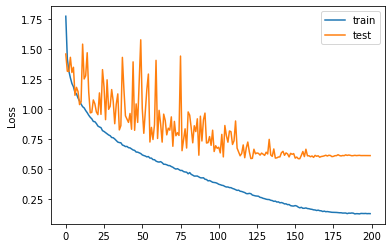

In [38]:
plt.plot(train_stat[:,1], label='train')
plt.plot(test_stat[:,1], label='test')
plt.ylabel("Loss")
plt.legend()
plt.savefig(f"./output/plots/{model_name}_loss.svg")
plt.show()

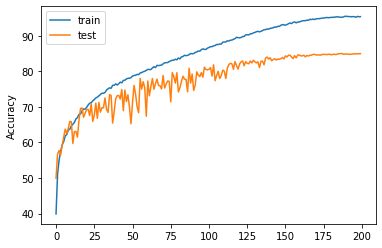

In [39]:
plt.plot(train_stat[:,2], label='train')
plt.plot(test_stat[:,2], label='test')
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(f"./output/plots/{model_name}_accs.svg")
plt.show()